In [ ]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

std=StandardScaler()
# set up everything so that the figures show up in the notebook
init_notebook_mode(connected=True)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tools.eval_measures import rmse, aic

filterwarnings('ignore')

# Indeed data modeling

## Load data

In [ ]:
df_indeed = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/Indeed_DSJobs_20200802_combined.csv')
df_indeed.head()

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City
0,Senior Data Analyst,Pack Health,Alabama,"Birmingham, AL 35203 (Fountain Heights area)",3 days ago,NaN,Analyzing and reporting of health outcomes and...,Pack Health is a digital health coaching platf...,AL,2020-07-30,Thu,Birmingham
1,"Interdisciplinary Economist, Mathematician or ...",US Department of the Treasury,Alabama,"Birmingham, AL",4 days ago,"$108,095 - $157,709 a year",Serve as a subject matter expert in predictive...,Duties Summary PLEASE NOTE: Based on the curre...,AL,2020-07-29,Wed,Birmingham
2,"Interdisciplinary, Economist, Mathematician or...",US Department of the Treasury,Alabama,"Birmingham, AL",4 days ago,"$108,095 - $157,709 a year",Serve as a subject matter expert in predictive...,Duties Summary PLEASE NOTE: Based on the curre...,AL,2020-07-29,Wed,Birmingham
3,Data Scientist - Machine Learning (#1463993),PeopleTec,Alabama,"Huntsville, AL 35806",11 days ago,NaN,Strong problem-solving skills with an emphasis...,PeopleTec is currently seeking a Machine Learn...,AL,2020-07-22,Wed,Huntsville
4,Machine Learning Engineer,Davidson Technologies Inc.,Alabama,"Huntsville, AL 35806",13 days ago,$48 - $85 an hour,Experience with machine learning API such as: ...,Requirements:Bachelor’s degree in Computer Sci...,AL,2020-07-20,Mon,Huntsville


In [ ]:
bydate = df_indeed.groupby('Post date').size()

df_date_indeed = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_indeed['Date'], y=df_date_indeed['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist open positions vs. post date')
fig.show()

In [ ]:
df_date_indeed['Date'] = pd.to_datetime(df_date_indeed['Date'])
df_date_indeed.set_index('Date', drop=False, inplace=True)

In [ ]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_indeed['Day of week'] = df_date_indeed['Date'].apply(lambda x: week[x.weekday()])

In [ ]:
df_date_indeed['Weekend'] = df_date_indeed['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)
df_date_indeed.at['2020-05-25','Weekend'] = 1 # memorial day

In [ ]:
df_date_indeed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2020-05-19 to 2020-08-02
Data columns (total 4 columns):
Date           76 non-null datetime64[ns]
Jobnums        76 non-null int64
Day of week    76 non-null object
Weekend        76 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.5+ KB


Text(0.5, 0, ' ')

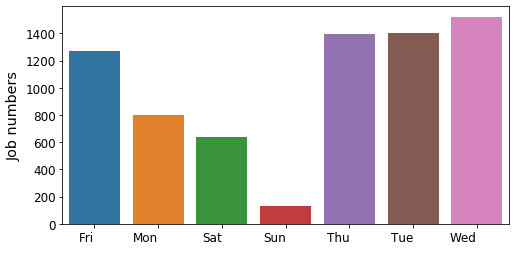

In [ ]:
by_weekday = df_date_indeed.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday)
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Load Covid-19 Data

In [ ]:
df_covid = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/covid_19_data.csv')
df_covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
df_us = df_covid[df_covid['Country/Region']=='US'].reset_index(drop=True)
df_us['ObservationDate'] = pd.to_datetime(df_us['ObservationDate'])
bydate_us = df_us.groupby('ObservationDate').sum()
bydate_us.drop('SNo', axis=1, inplace=True)

In [ ]:
bydate_us['Active'] = bydate_us['Confirmed'] - bydate_us['Deaths'] - bydate_us['Recovered']
bydate_us['New'] = bydate_us['Confirmed'].diff()
bydate_us.at['2020-01-22','New'] = 0.0
bydate_us['Fatality'] = bydate_us['Deaths']/bydate_us['Confirmed']*100

In [ ]:
bydate_us

,Confirmed,Deaths,Recovered,Active,New,Fatality
ObservationDate,,,,,,
2020-01-22,1.0,0.0,0.0,1.0,0.0,0.000000
2020-01-23,1.0,0.0,0.0,1.0,0.0,0.000000
2020-01-24,2.0,0.0,0.0,2.0,1.0,0.000000
2020-01-25,2.0,0.0,0.0,2.0,0.0,0.000000
2020-01-26,5.0,0.0,0.0,5.0,3.0,0.000000
...,...,...,...,...,...,...
2020-08-03,4713540.0,155402.0,1513446.0,3044692.0,45585.0,3.296928
2020-08-04,4771080.0,156801.0,1528979.0,3085300.0,57540.0,3.286489
2020-08-05,4823890.0,158250.0,1577851.0,3087789.0,52810.0,3.280547


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Confirmed'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Deaths'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Recovered'], mode='lines', name='Recovered'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Active'], mode='lines', name='Active'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['New'], mode='lines', name='New'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Fatality'], mode='lines', name='Fatality Rate'))

fig.update_layout(title='US COVID-19 Cases')
fig.show()

## Combine Data

In [ ]:
df_covid_trunc1 = bydate_us['2020-05-19':'2020-08-02']
df_indeed_trunc = df_date_indeed['2020-05-19':'2020-08-02']

df_combined_indeed = pd.concat([df_indeed_trunc, df_covid_trunc1], axis=1)
df_combined_indeed.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
2020-05-19,2020-05-19,45,Tue,0,1528568.0,91921.0,289392.0,1147255.0,20260.0,6.013537
2020-05-20,2020-05-20,57,Wed,0,1551853.0,93439.0,294312.0,1164102.0,23285.0,6.021124
2020-05-21,2020-05-21,47,Thu,0,1577147.0,94702.0,298418.0,1184027.0,25294.0,6.004640
2020-05-22,2020-05-22,51,Fri,0,1600937.0,95979.0,350135.0,1154823.0,23790.0,5.995177
2020-05-23,2020-05-23,51,Sat,1,1622612.0,97087.0,361239.0,1164286.0,21675.0,5.983377


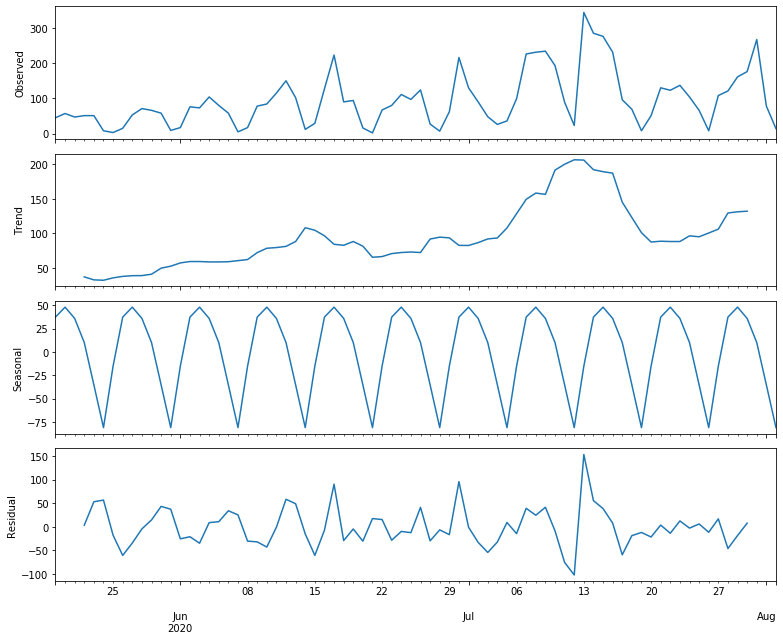

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

y=df_combined_indeed['Jobnums']
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Grid Search

In [ ]:
def diff_transform(df_train,  d):
    """take difference"""
    df_diff = df_train.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            df_diff[str(col)+'_1d'] = df_diff[col].diff().fillna(0)
            df_diff.drop(columns=[col],inplace=True)
            if d>1:
                df_diff[str(col)+'_2d'] = df_diff[str(col)+'_1d'].diff().fillna(0)
                df_diff.drop(columns=[str(col)+'_1d'],inplace=True)
            
    return df_diff

In [ ]:
def invert_transform(df_train, df_forecast, d):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            # Roll back 2nd Diff
            if d==2:
                df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
                df_fc.drop(columns=[str(col)+'_2d'],inplace=True)
            # Roll back 1st Diff
            df_fc[col] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
            df_fc.drop(columns=[str(col)+'_1d'],inplace=True)
    return df_fc

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def measure_rmse(actual, predicted):
    return rmse(actual, predicted)

def varmax_forecast(train, test_len, config, exog1=None, exog2=None):
    order, trend, d= config
    #d parameter to take difference
    df_diff = diff_transform(train,  d)
    try:
        model = VARMAX(df_diff, order=order, trend=trend, exog=exog1, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        yhat_diff = model_fit.forecast(steps=test_len, exog=exog2)
        yhat = invert_transform(train, yhat_diff, d)
    except:
        yhat = None
    return yhat

def single_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        yhat = varmax_forecast(train, len(test), cfg, exog1=exog_train, exog2=exog_test)
    else:
        yhat = varmax_forecast(train, len(test), cfg)
    if yhat is not None:
        error = measure_rmse(test['Jobnums'], yhat['Jobnums'])
    else:
        error = None
    return error

def walk_forward_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error

def score_model(data, n_test, cfg, method, exog=None, debug=True):
    result = None
    key = str(cfg)
    if debug:
        if method=='walk':
            result = walk_forward_validation(data, n_test, cfg, exog)
        else:
            result = single_validation(data, n_test, cfg, exog)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                if method=='walk':
                    result = walk_forward_validation(data, n_test, cfg, exog)
                else:
                    result = single_validation(data, n_test, cfg, exog)
        except:
            error = None
    if result is not None:
        print('---> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(data, cfg_list, n_test, method, exog=None, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, method, exog) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, method, exog) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def varmax_configs():
    models = list()
    p_params = [3, 4, 5, 6, 7, 8, 9, 10]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    d_params = [0, 1, 2]
    
    for p in p_params:
        for q in q_params:
            for t in t_params:
                for d in d_params:
                    cfg = [(p,q), t, d]
                    models.append(cfg)
    return models

In [ ]:
def walk_forward_best(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error

#### No eXog + Walk

In [ ]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=None, parallel=False)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 0]] 82.600
---> Model[[(3, 0), 'n', 1]] 116.131
---> Model[[(3, 0), 'n', 2]] 148.692
---> Model[[(3, 0), 'c', 0]] 83.483
---> Model[[(3, 0), 'c', 1]] 120.581
---> Model[[(3, 0), 'c', 2]] 149.276
---> Model[[(3, 0), 't', 0]] 89.083
---> Model[[(3, 0), 't', 1]] 123.672
---> Model[[(3, 0), 't', 2]] 151.055
---> Model[[(3, 0), 'ct', 0]] 87.449
---> Model[[(3, 0), 'ct', 1]] 123.232
---> Model[[(3, 0), 'ct', 2]] 151.442
---> Model[[(3, 1), 'n', 0]] 82.902
---> Model[[(3, 1), 'n', 1]] 118.426
---> Model[[(3, 1), 'n', 2]] 169.802
---> Model[[(3, 1), 'c', 0]] 91.647
---> Model[[(3, 1), 'c', 1]] 121.846
---> Model[[(3, 1), 'c', 2]] 154.556
---> Model[[(3, 1), 't', 0]] 93.825
---> Model[[(3, 1), 't', 1]] 123.833
---> Model[[(3, 1), 't', 2]] 156.807
---> Model[[(3, 1), 'ct', 0]] 88.994
---> Model[[(3, 1), 'ct', 1]] 123.596
---> Model[[(3, 1), 'ct', 2]] 154.100
---> Model[[(3, 2), 'n', 0]] 78.965
---> Model[[(3, 2), 'n', 1]] 103.621
---> Model[[(3, 2), 'n', 2]] 125.308
--->

---> Model[[(9, 0), 't', 2]] 103.899
---> Model[[(9, 0), 'ct', 0]] 88.235
---> Model[[(9, 0), 'ct', 1]] 100.281
---> Model[[(9, 0), 'ct', 2]] 102.199
---> Model[[(9, 1), 'n', 0]] 106.743
---> Model[[(9, 1), 'n', 1]] 94.546
---> Model[[(9, 1), 'n', 2]] 101.059
---> Model[[(9, 1), 'c', 0]] 109.427
---> Model[[(9, 1), 'c', 1]] 94.168
---> Model[[(9, 1), 'c', 2]] 109.532
---> Model[[(9, 1), 't', 0]] 111.159
---> Model[[(9, 1), 't', 1]] 94.258
---> Model[[(9, 1), 't', 2]] 112.134
---> Model[[(9, 1), 'ct', 0]] 94.229
---> Model[[(9, 1), 'ct', 1]] 98.075
---> Model[[(9, 1), 'ct', 2]] 104.845
---> Model[[(9, 2), 'n', 0]] 92.549
---> Model[[(9, 2), 'n', 1]] 90.479
---> Model[[(9, 2), 'n', 2]] 123.001
---> Model[[(9, 2), 'c', 0]] 89.024
---> Model[[(9, 2), 'c', 1]] 91.603
---> Model[[(9, 2), 'c', 2]] 104.321
---> Model[[(9, 2), 't', 0]] 99.074
---> Model[[(9, 2), 't', 1]] 95.157
---> Model[[(9, 2), 't', 2]] 101.358
---> Model[[(9, 2), 'ct', 0]] 90.187
---> Model[[(9, 2), 'ct', 1]] 99.687
---> Mo

In [ ]:
best_cfg = [(8, 1), 'ct', 0]
n_test = 7
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_varma, error = walk_forward_best(indeed_data, n_test, best_cfg)

#### X=weekend + Walk

In [ ]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=df_combined_indeed[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 1]] 88.597
---> Model[[(3, 0), 'n', 2]] 130.311
---> Model[[(3, 0), 'n', 0]] 64.750
---> Model[[(3, 0), 'c', 0]] 62.775
---> Model[[(3, 0), 'c', 1]] 58.393
---> Model[[(3, 0), 'c', 2]] 124.651
---> Model[[(3, 0), 't', 0]] 74.827
---> Model[[(3, 0), 't', 1]] 82.444
---> Model[[(3, 0), 't', 2]] 129.397
---> Model[[(3, 0), 'ct', 0]] 63.382
---> Model[[(3, 0), 'ct', 1]] 57.230
---> Model[[(3, 0), 'ct', 2]] 126.127
---> Model[[(3, 1), 'n', 0]] 72.988
---> Model[[(3, 1), 'n', 1]] 92.067
---> Model[[(3, 1), 'n', 2]] 105.932
---> Model[[(3, 1), 'c', 0]] 63.832
---> Model[[(3, 1), 'c', 1]] 49.875
---> Model[[(3, 1), 't', 0]] 74.138
---> Model[[(3, 1), 'c', 2]] 100.108
---> Model[[(3, 1), 't', 1]] 73.924
---> Model[[(3, 1), 't', 2]] 101.562
---> Model[[(3, 1), 'ct', 0]] 61.878
---> Model[[(3, 1), 'ct', 1]] 51.198
---> Model[[(3, 1), 'ct', 2]] 108.687
---> Model[[(3, 2), 'n', 0]] 82.017
---> Model[[(3, 2), 'n', 1]] 85.053
---> Model[[(3, 2), 'n', 2]] 96.218
---> Model[[(3

---> Model[[(9, 0), 'ct', 1]] 64.753
---> Model[[(9, 0), 'ct', 2]] 117.624
---> Model[[(9, 1), 'n', 0]] 82.716
---> Model[[(9, 1), 'n', 1]] 91.870
---> Model[[(9, 1), 'n', 2]] 102.379
---> Model[[(9, 1), 'c', 0]] 76.712
---> Model[[(9, 1), 'c', 1]] 63.175
---> Model[[(9, 1), 'c', 2]] 87.455
---> Model[[(9, 1), 't', 0]] 88.499
---> Model[[(9, 1), 't', 1]] 82.441
---> Model[[(9, 1), 't', 2]] 108.072
---> Model[[(9, 1), 'ct', 0]] 77.583
---> Model[[(9, 1), 'ct', 1]] 61.814
---> Model[[(9, 1), 'ct', 2]] 107.363
---> Model[[(9, 2), 'n', 0]] 97.192
---> Model[[(9, 2), 'n', 1]] 89.926
---> Model[[(9, 2), 'n', 2]] 113.292
---> Model[[(9, 2), 'c', 0]] 67.879
---> Model[[(9, 2), 'c', 1]] 65.117
---> Model[[(9, 2), 'c', 2]] 91.649
---> Model[[(9, 2), 't', 0]] 80.142
---> Model[[(9, 2), 't', 1]] 82.749
---> Model[[(9, 2), 't', 2]] 112.250
---> Model[[(9, 2), 'ct', 0]] 73.017
---> Model[[(9, 2), 'ct', 1]] 63.034
---> Model[[(10, 0), 'n', 0]] 103.818
---> Model[[(9, 2), 'ct', 2]] 108.103
---> Model[

In [ ]:
n_test = 7
best_cfg = [(5, 0), 'c', 1]
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_varmax, errorx = walk_forward_best(indeed_data, n_test, best_cfg, exog=df_combined_indeed[['Weekend']])

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error), 'X=Weekend, RMSE: {:0.2f}'.format(errorx)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='Indeed Data Scientist Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the future

In [ ]:
df_indeed_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_indeed_future['Date'] = pd.date_range('2020-08-03', '2020-08-09')
df_indeed_future.set_index('Date', inplace=True, drop=False)
df_indeed_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_indeed_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_indeed_future

,Date,Day of week,Weekend
Date,,,
2020-08-03,2020-08-03,Mon,0
2020-08-04,2020-08-04,Tue,0
2020-08-05,2020-08-05,Wed,0
2020-08-06,2020-08-06,Thu,0
2020-08-07,2020-08-07,Fri,0
2020-08-08,2020-08-08,Sat,1
2020-08-09,2020-08-09,Sun,1


In [ ]:
n_test = 7
best_cfg = [(5, 0), 'c', 1]
train = df_combined_indeed[['New','Jobnums']]
exog_train = df_combined_indeed[['Weekend']]
exog_test = df_indeed_future[['Weekend']]
indeed_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    indeed_pred = indeed_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [ ]:
#single forecast
yhat_fcast = varmax_forecast(train, n_test, best_cfg, exog1=exog_train, exog2=exog_test)

In [ ]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_indeed_future.index[0],
            y0=0,
            x1=df_indeed_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_indeed.index, y=df_combined_indeed['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_indeed_future.index, y=indeed_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))
#fig.add_trace(go.Scatter(x=df_indeed_future.index, y=yhat_fcast['Jobnums'], mode='lines+markers', 
#                         marker=dict(size=8, color='green'), name='Future Forecast'))

# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,1],
#                          fill='tonexty',
#                          mode='lines', line_color='lightgrey',line_width=0,
#                          showlegend=False))
# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,0],
#                          fill='tonexty',
#                          mode='lines', line_color='grey', opacity=0.1, line_width=0,
#                          showlegend=False))

fig.add_annotation(
            x='2020-08-05',
            y=285,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "Indeed Data Scientist Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

# LinkedIn Data Modeling

## Load data

In [ ]:
df_linkedin = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/linkedin_ds_080620_combined.csv')
df_linkedin.head()

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,"Data Analyst, Business Office, FT",Community Health Systems,"Huntsville, Alabama, United States",2020-08-06,Associate,Full-time,"Staffing and Recruiting,Health, Wellness and F...",Job DescriptionMaintain Patient Day Spreadshee...,Alabama,AL
1,Data Scientist / Process Engineer,Evonik,"Mobile, Alabama, United States",2020-08-04,Entry level,Full-time,"Chemicals,Mechanical or Industrial Engineering...",Discover a world of opportunities. #HumanChemi...,Alabama,AL
2,DATA SCIENCE CONSULTANT BIRMINGHAM,Management Solutions,"Birmingham, Alabama, United States",2020-08-03,Entry level,Full-time,Management Consulting,Management Solutions is an international consu...,Alabama,AL
3,Senior Operations Research Analyst,MITRE,"Huntsville, Alabama, United States",2020-08-03,Associate,Full-time,"Information Technology and Services,Defense & ...",Why choose between doing meaningful work and h...,Alabama,AL
4,Data Analyst (Data Scientist Program),Brooksource,"Huntsville, Alabama, United States",2020-08-03,Entry level,Contract,Information Technology and Services,Data Analyst (Data Scientist Program) Huntsvil...,Alabama,AL


In [ ]:
bydate = df_linkedin.groupby('Date').size()

df_date_linkedin = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})
df_date_linkedin['Date'] = pd.to_datetime(df_date_linkedin['Date'])
df_date_linkedin.set_index('Date', inplace=True, drop=False)

In [ ]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_linkedin['Day of week'] = df_date_linkedin['Date'].apply(lambda x: week[x.weekday()])

In [ ]:
df_date_linkedin['Weekend'] = df_date_linkedin['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)
df_date_linkedin.at['2020-05-25','Weekend'] = 1 # memorial day

In [ ]:
df_date_linkedin_trunc = df_date_linkedin['2020-05-19':'2020-08-02']

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_linkedin_trunc.index, y=df_date_linkedin_trunc['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist(LinkedIn) open positions vs. post date')
fig.show()

Text(0.5, 0, ' ')

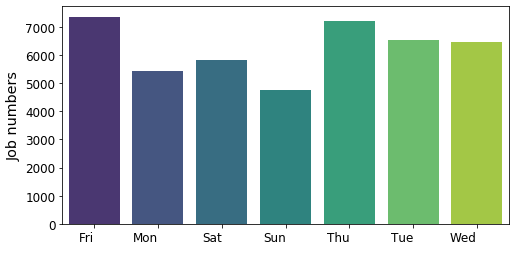

In [ ]:
by_weekday = df_date_linkedin_trunc.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday, palette='viridis')
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Combine with COVID-19 

In [ ]:
df_covid_trunc = bydate_us['2020-05-19':'2020-08-02']

df_combined_linkedin = pd.concat([df_date_linkedin_trunc, df_covid_trunc], axis=1)
df_combined_linkedin

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
2020-05-19,2020-05-19,427,Tue,0,1528568.0,91921.0,289392.0,1147255.0,20260.0,6.013537
2020-05-20,2020-05-20,108,Wed,0,1551853.0,93439.0,294312.0,1164102.0,23285.0,6.021124
2020-05-21,2020-05-21,89,Thu,0,1577147.0,94702.0,298418.0,1184027.0,25294.0,6.004640
2020-05-22,2020-05-22,125,Fri,0,1600937.0,95979.0,350135.0,1154823.0,23790.0,5.995177
2020-05-23,2020-05-23,270,Sat,1,1622612.0,97087.0,361239.0,1164286.0,21675.0,5.983377
...,...,...,...,...,...,...,...,...,...,...
2020-07-29,2020-07-29,459,Wed,0,4426982.0,150713.0,1389425.0,2886844.0,70776.0,3.404419
2020-07-30,2020-07-30,535,Thu,0,4495015.0,152055.0,1414155.0,2928805.0,68033.0,3.382747
2020-07-31,2020-07-31,555,Fri,0,4562038.0,153314.0,1438160.0,2970564.0,67023.0,3.360647
2020-08-01,2020-08-01,682,Sat,1,4620444.0,154447.0,1461885.0,3004112.0,58406.0,3.342687


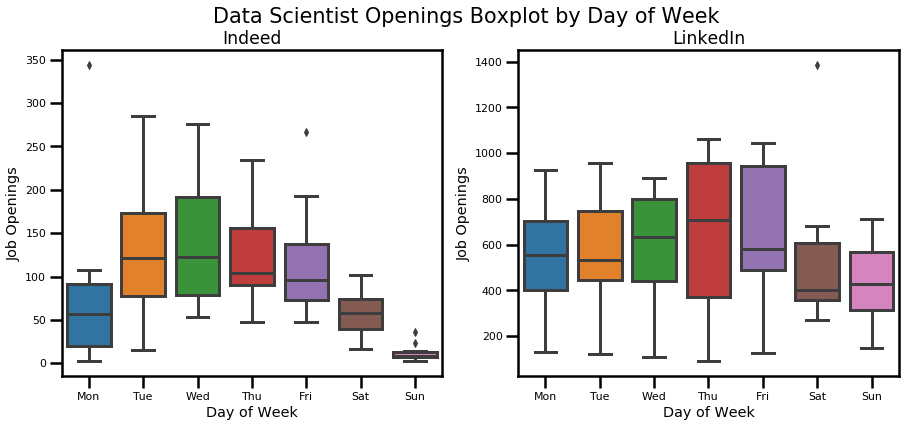

In [ ]:
plt.figure(figsize=(15,6))
sns.set_context('poster',font_scale=0.5)
plt.subplot(121)
sns.boxplot(data=df_combined_indeed, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('Indeed', fontsize='x-large')
plt.subplot(122)
sns.boxplot(data=df_combined_linkedin, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('LinkedIn', fontsize='x-large')
plt.suptitle('Data Scientist Openings Boxplot by Day of Week', fontsize='xx-large')
plt.show()

## Grid Search

In [ ]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'No eXog', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 1]] 138.180
---> Model[[(3, 0), 'n', 2]] 165.065
---> Model[[(3, 0), 'n', 0]] 87.785
---> Model[[(3, 0), 'c', 1]] 135.185
---> Model[[(3, 0), 'c', 2]] 164.710
---> Model[[(3, 0), 'c', 0]] 76.099
---> Model[[(3, 0), 't', 1]] 142.483
---> Model[[(3, 0), 't', 0]] 80.677
---> Model[[(3, 0), 't', 2]] 170.390
---> Model[[(3, 0), 'ct', 0]] 185.300
---> Model[[(3, 0), 'ct', 1]] 154.253
---> Model[[(3, 0), 'ct', 2]] 173.357
---> Model[[(3, 1), 'n', 0]] 117.772
---> Model[[(3, 1), 'n', 1]] 165.385
---> Model[[(3, 1), 'n', 2]] 164.634
---> Model[[(3, 1), 'c', 0]] 92.142
---> Model[[(3, 1), 'c', 1]] 164.574
---> Model[[(3, 1), 'c', 2]] 181.260
---> Model[[(3, 1), 't', 0]] 82.535
---> Model[[(3, 1), 't', 1]] 161.236
---> Model[[(3, 1), 't', 2]] 218.955
---> Model[[(3, 1), 'ct', 0]] 136.168
---> Model[[(3, 1), 'ct', 1]] 171.379
---> Model[[(3, 1), 'ct', 2]] 205.338
---> Model[[(3, 2), 'n', 0]] 110.471
---> Model[[(3, 2), 'n', 1]] 156.301
---> Model[[(3, 2), 'n', 2]] 122.984


---> Model[[(9, 0), 'c', 2]] 302.110
---> Model[[(9, 0), 't', 0]] 202.307
---> Model[[(9, 0), 't', 1]] 278.929
---> Model[[(9, 0), 't', 2]] 304.669
---> Model[[(9, 0), 'ct', 0]] 226.411
---> Model[[(9, 0), 'ct', 1]] 279.769
---> Model[[(9, 0), 'ct', 2]] 304.001
---> Model[[(9, 1), 'n', 0]] 260.619
---> Model[[(9, 1), 'n', 1]] 292.832
---> Model[[(9, 1), 'n', 2]] 315.307
---> Model[[(9, 1), 'c', 0]] 279.308
---> Model[[(9, 1), 'c', 1]] 293.065
---> Model[[(9, 1), 'c', 2]] 311.439
---> Model[[(9, 1), 't', 0]] 202.687
---> Model[[(9, 1), 't', 1]] 294.869
---> Model[[(9, 1), 't', 2]] 304.451
---> Model[[(9, 1), 'ct', 0]] 254.616
---> Model[[(9, 1), 'ct', 1]] 290.480
---> Model[[(9, 1), 'ct', 2]] 293.234
---> Model[[(9, 2), 'n', 0]] 248.654
---> Model[[(9, 2), 'n', 1]] 293.894
---> Model[[(9, 2), 'n', 2]] 284.984
---> Model[[(9, 2), 'c', 1]] 287.983
---> Model[[(9, 2), 'c', 0]] 208.638
---> Model[[(9, 2), 'c', 2]] 278.675
---> Model[[(9, 2), 't', 0]] 218.931
---> Model[[(9, 2), 't', 1]] 289

In [ ]:
best_cfg = [(3, 2), 't', 0]
n_test = 7
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_varma, error = walk_forward_best(data, n_test, best_cfg)

### X=Weekend

In [ ]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method,exog=df_combined_linkedin[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'X=weekend', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 2]] 176.180
---> Model[[(3, 0), 'n', 1]] 185.708
---> Model[[(3, 0), 'n', 0]] 64.623
---> Model[[(3, 0), 'c', 0]] 111.316
---> Model[[(3, 0), 'c', 1]] 185.024
---> Model[[(3, 0), 'c', 2]] 150.375
---> Model[[(3, 0), 't', 0]] 79.904
---> Model[[(3, 0), 't', 1]] 159.160
---> Model[[(3, 0), 't', 2]] 147.150
---> Model[[(3, 0), 'ct', 0]] 186.045
---> Model[[(3, 0), 'ct', 1]] 225.575
---> Model[[(3, 0), 'ct', 2]] 157.923
---> Model[[(3, 1), 'n', 1]] 183.254
---> Model[[(3, 1), 'n', 0]] 93.946
---> Model[[(3, 1), 'n', 2]] 178.696
---> Model[[(3, 1), 'c', 0]] 107.363
---> Model[[(3, 1), 'c', 2]] 154.989
---> Model[[(3, 1), 'c', 1]] 237.477
---> Model[[(3, 1), 't', 0]] 88.339
---> Model[[(3, 1), 't', 1]] 232.520
---> Model[[(3, 1), 't', 2]] 203.409
---> Model[[(3, 1), 'ct', 0]] 142.184
---> Model[[(3, 1), 'ct', 1]] 250.735
---> Model[[(3, 1), 'ct', 2]] 118.348
---> Model[[(3, 2), 'n', 0]] 155.533
---> Model[[(3, 2), 'n', 1]] 189.755
---> Model[[(3, 2), 'n', 2]] 210.206

---> Model[[(9, 0), 'c', 2]] 347.991
---> Model[[(9, 0), 't', 0]] 188.972
---> Model[[(9, 0), 't', 1]] 272.612
---> Model[[(9, 0), 't', 2]] 322.334
---> Model[[(9, 0), 'ct', 0]] 206.672
---> Model[[(9, 0), 'ct', 1]] 274.989
---> Model[[(9, 0), 'ct', 2]] 305.166
---> Model[[(9, 1), 'n', 0]] 192.104
---> Model[[(9, 1), 'n', 1]] 306.825
---> Model[[(9, 1), 'n', 2]] 321.099
---> Model[[(9, 1), 'c', 0]] 288.061
---> Model[[(9, 1), 'c', 1]] 303.762
---> Model[[(9, 1), 'c', 2]] 344.380
---> Model[[(9, 1), 't', 0]] 196.751
---> Model[[(9, 1), 't', 1]] 304.285
---> Model[[(9, 1), 't', 2]] 345.661
---> Model[[(9, 1), 'ct', 0]] 179.591
---> Model[[(9, 1), 'ct', 1]] 308.264
---> Model[[(9, 1), 'ct', 2]] 323.347
---> Model[[(9, 2), 'n', 0]] 193.896
---> Model[[(9, 2), 'n', 1]] 309.946
---> Model[[(9, 2), 'n', 2]] 304.046
---> Model[[(9, 2), 'c', 0]] 296.692
---> Model[[(9, 2), 'c', 1]] 299.612
---> Model[[(9, 2), 'c', 2]] 311.503
---> Model[[(9, 2), 't', 0]] 213.437
---> Model[[(9, 2), 't', 1]] 302

In [ ]:
n_test = 7
best_cfg = [(3, 0), 'n', 0]
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_varmax, errorx = walk_forward_best(data, n_test, best_cfg, exog=df_combined_linkedin[['Weekend']])

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error), 'X=Weekend, RMSE: {:0.2f}'.format(errorx)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='LinkedIn Data Scientist Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the future

In [ ]:
df_linkedin_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_linkedin_future['Date'] = pd.date_range('2020-08-03', '2020-08-09')
df_linkedin_future.set_index('Date', inplace=True, drop=False)
df_linkedin_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_linkedin_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_linkedin_future

,Date,Day of week,Weekend
Date,,,
2020-08-03,2020-08-03,Mon,0
2020-08-04,2020-08-04,Tue,0
2020-08-05,2020-08-05,Wed,0
2020-08-06,2020-08-06,Thu,0
2020-08-07,2020-08-07,Fri,0
2020-08-08,2020-08-08,Sat,1
2020-08-09,2020-08-09,Sun,1


In [ ]:
n_test = 7
best_cfg = [(3, 0), 'n', 0]
train = df_combined_linkedin[['New','Jobnums']]
exog_train = df_combined_linkedin[['Weekend']]
exog_test = df_linkedin_future[['Weekend']]
linkedin_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    linkedin_pred = linkedin_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [ ]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_linkedin_future.index[0],
            y0=0,
            x1=df_linkedin_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_linkedin.index, y=df_combined_linkedin['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_linkedin_future.index, y=linkedin_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))


fig.add_annotation(
            x='2020-08-06',
            y=620,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "LinkedIn Data Scientist Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()